# Assignment 2
## Facial Point Detection

This assignment approaches the computer vision problem of detecting facial keypoints in an image using deep learning techniques.

The training dataset consists of 7,049 96x96 gray-scale images. For each image, we're supposed learn to find the correct position (the ``x`` and ``y`` coordinates) of 15 2D keypoints, such as ``left_eye_center, right_eye_outer_corner, mouth_center_bottom_lip``, and so on. For some of the keypoints we only have about 2,000 labels, while other keypoints have more than 7,000 labels available for training.

In the following lines we provide a simple solution. This model can be used to provide a baseline result to be used for comparison.

The objectives of this assignment are:
+ To develop a better solution by changing the baseline model.
+ To increase performance by using several tricks:
    + Data augmentation: flipped images, greylevel image editing, etc.
    + Changing learning rate and momentum over time.
    + Using regularization techniques such as Dropout.
    + Instead of training a single model, train a few specialist networks, with each one predicting a different subset of target values (f.e. eye features, mouth features, etc.).
    + Etc.

> You will need **GPU computation**. Consider the use of Colab!
    
At the end of the notebook you must report:
+ What is the best result you got when testing.
+ What architecture and tricks you used for that result.

The final model can be developed in Tensorflow or in Keras.

In [ ]:
%matplotlib inline

import numpy as np
import matplotlib
from matplotlib import pyplot
import os
import time

from pandas import DataFrame
from pandas.io.parsers import read_csv
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import tensorflow as tf

import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping

Upload the `test.csv` and `training.csv` files that you can download from campus virtual.

In [ ]:
# Mount Google Drive to access files in Google Colab
from google.colab import drive
drive.mount('/content/driveMyDrive/')

Drive already mounted at /content/driveMyDrive/; to attempt to forcibly remount, call drive.mount("/content/driveMyDrive/", force_remount=True).


In [ ]:
# loading data

FTRAIN = '/content/driveMyDrive/MyDrive/training.csv'
FTEST = '/content/drive/MyDrive/test.csv'

def load(test = False, cols = None):
    """
    Loads the dataset.
    Returns a tuple of X and y, if `test` was set to `True` y contains `None`.
    """

    fname = FTEST if test else FTRAIN
    df = read_csv(os.path.expanduser(fname))  # load pandas dataframe

    # The Image column has pixel values separated by space; convert
    # the values to numpy arrays:
    df['Image'] = df['Image'].apply(lambda im: np.fromstring(im, sep = ' '))

    if cols:  # get a subset of columns
        df = df[list(cols) + ['Image']]
    df = df.dropna()  # drop all rows that have missing values in them
    print("\n")

    X = np.row_stack(df['Image'].values) / 255.  # scale pixel values to [0, 1]
    X = X.astype(np.float32)

    print("Number of samples in", fname, ":",len(X))
    print("Labels: ", df.columns.tolist())

    if not test:  # only FTRAIN has any target columns
        y = df[df.columns[:-1]].values
        y = (y - 48) / 48  # scale target coordinates to [-1, 1]
        X, y = shuffle(X, y, random_state=42)  # shuffle train data
        y = y.astype(np.float32)
    else:
        y = None
    return X.reshape(df.shape[0],96,96), y

def plot_sample(x, y):
    """
    Plots a single sample image with keypoints on top.
    """
    pyplot.imshow(x, cmap='gray')
    pyplot.scatter(y[0::2] * 48 + 48, y[1::2] * 48 + 48, marker='x', s=10)




Number of samples in /content/driveMyDrive/MyDrive/training.csv : 2140
Labels:  ['left_eye_center_x', 'left_eye_center_y', 'right_eye_center_x', 'right_eye_center_y', 'left_eye_inner_corner_x', 'left_eye_inner_corner_y', 'left_eye_outer_corner_x', 'left_eye_outer_corner_y', 'right_eye_inner_corner_x', 'right_eye_inner_corner_y', 'right_eye_outer_corner_x', 'right_eye_outer_corner_y', 'left_eyebrow_inner_end_x', 'left_eyebrow_inner_end_y', 'left_eyebrow_outer_end_x', 'left_eyebrow_outer_end_y', 'right_eyebrow_inner_end_x', 'right_eyebrow_inner_end_y', 'right_eyebrow_outer_end_x', 'right_eyebrow_outer_end_y', 'nose_tip_x', 'nose_tip_y', 'mouth_left_corner_x', 'mouth_left_corner_y', 'mouth_right_corner_x', 'mouth_right_corner_y', 'mouth_center_top_lip_x', 'mouth_center_top_lip_y', 'mouth_center_bottom_lip_x', 'mouth_center_bottom_lip_y', 'Image']

 Sample image with labels:


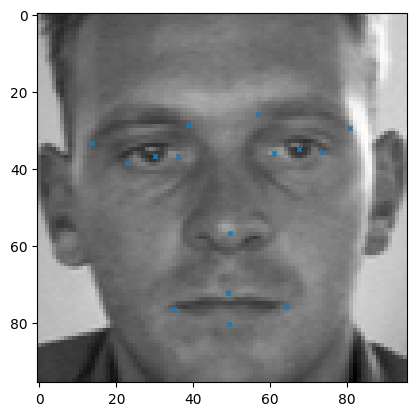

In [ ]:
# loading data

X, y = load()

print("\n Sample image with labels:")
plot_sample(X[13],y[13])

In [ ]:
# Split the initial training dataset into training, validation and testing datasets.

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
x_test, x_valid, y_test, y_valid = train_test_split(x_test, y_test, test_size = 0.5)

# Make sure images have shape (28, 28, 1) - Keras requirement!
x_train = np.expand_dims(x_train, -1)
x_valid = np.expand_dims(x_valid, -1)
x_test = np.expand_dims(x_test, -1)

print(f'Training set x :{x_train.shape}')
print(f'Training set y :{y_train.shape}')
print(f'Validation set x: {x_valid.shape}')
print(f'Validation set y: {y_valid.shape}')
print(f'Test set x :{x_test.shape}')

Training set x :(1712, 96, 96, 1)
Training set y :(1712, 30)
Validation set x: (214, 96, 96, 1)
Validation set y: (214, 30)
Test set x :(214, 96, 96, 1)


## My solution:

In [ ]:
from scipy.ndimage import gaussian_filter

# Function for data augmentation
def data_augmentation(x, y, numImg, horizontal = False, drop_out = True, perc=0.05):

  # Print shapes before augmentation
  print(f'Training set before augmentation x :{x.shape}')
  print(f'Training set before augmentation y :{y.shape}')

  # Define facial keypoint columns
  columns = ["left_eye_center_x", "left_eye_center_y", "right_eye_center_x", "right_eye_center_y", "left_eye_inner_corner_x", "left_eye_inner_corner_y", "left_eye_outer_corner_x", "left_eye_outer_corner_y", "right_eye_inner_corner_x", "right_eye_inner_corner_y", "right_eye_outer_corner_x", "right_eye_outer_corner_y", "left_eyebrow_inner_end_x", "left_eyebrow_inner_end_y", "left_eyebrow_outer_end_x", "left_eyebrow_outer_end_y", "right_eyebrow_inner_end_x", "right_eyebrow_inner_end_y", "right_eyebrow_outer_end_x", "right_eyebrow_outer_end_y", "nose_tip_x", "nose_tip_y", "mouth_left_corner_x", "mouth_left_corner_y", "mouth_right_corner_x", "mouth_right_corner_y", "mouth_center_top_lip_x", "mouth_center_top_lip_y", "mouth_center_bottom_lip_x", "mouth_center_bottom_lip_y"]

  # Create copies of the original training set
  x_train_augmented = np.copy(x)
  y_train_augmented = np.copy(y)
  num_im = len(x)

  # Loop over each image for augmentation
  for i in range(numImg):
    image, labels = x[i], y[i]

    # Flip the images horizontally
    if horizontal:
      flipped_image_h = tf.image.flip_left_right(image).numpy()

      # Flip the x-coordinates of the keypoints
      flipped_labels_h = np.copy(labels)
      flipped_labels_h = flipped_labels_h.reshape((-1, 2))
      flipped_labels_h[:, 0] = -flipped_labels_h[:, 0]
      flipped_labels_h = flipped_labels_h.flatten() # back to the inital shape (30, 1)

      # Rearrange the array
      left_idx = [i for i, el in enumerate(columns) if 'left' in el]
      right_idx = [i for i, el in enumerate(columns) if 'right' in el]
      flipped_labels_h[left_idx], flipped_labels_h[right_idx] = flipped_labels_h[right_idx], flipped_labels_h[left_idx]

      # Add augmentation
      x_train_augmented = np.append(x_train_augmented, [flipped_image_h], axis=0)
      y_train_augmented = np.append(y_train_augmented, [flipped_labels_h], axis=0)

    # Apply Gaussian blur to the image
    blurred_image = gaussian_filter(image, sigma=np.random.uniform(0.5, 1.5))

    # Darker augmentation using random adjustment of brightness
    darkened_img = tf.image.adjust_brightness(image, delta = np.random.uniform(-1, 0)).numpy()

    # Lighter augmentation using random adjustment of brightness
    lighter_img = tf.image.adjust_brightness(image, delta = np.random.uniform(0, 1)).numpy()

    # Add augmented data to the training set
    x_train_augmented = np.append(x_train_augmented, [blurred_image, darkened_img, lighter_img], axis=0)
    y_train_augmented = np.append(y_train_augmented, [labels, labels, labels], axis=0)

    # Dropout augmentation by setting random pixels to zero
    if drop_out:
      num_pixels = int((image.shape[0]**2) * perc)
      indices_x = np.random.randint(0, image.shape[0], num_pixels)
      indices_y = np.random.randint(0, image.shape[1], num_pixels)
      drop_out_image = np.copy(image)
      drop_out_image[indices_x, indices_y, :] = 0
      # Add augmentation
      x_train_augmented = np.append(x_train_augmented, [drop_out_image], axis=0)
      y_train_augmented = np.append(y_train_augmented, [labels], axis=0)


  # Display the shape of the training set after augmentation
  print(f'Training set after x :{x_train_augmented.shape}')
  print(f'Training set after y :{y_train_augmented.shape}')

  return x_train_augmented, y_train_augmented


In [ ]:
# Data augmentation pipeline

# Get the number of images in the training set
numImg = x_train.shape[0]

# Apply data augmentation function to generate augmented training data
# Parameters:
#   - x_train: Input images
#   - y_train: Corresponding facial keypoint labels
#   - numImg: Number of images in the training set
#   - horizontal: Apply horizontal flip (True or False)
#   - drop_out: Apply pixel dropout (True or False)
#   - perc: Percentage of pixels to be dropped out in the dropout augmentation
x_train_augmented, y_train_augmented = data_augmentation(
    x_train, y_train, numImg,
    horizontal = True,  drop_out = True,
    perc = 0.05
)

Training set before augmentation x :(1712, 96, 96, 1)
Training set before augmentation y :(1712, 30)
Training set after x :(10272, 96, 96, 1)
Training set after y :(10272, 30)


In [ ]:
import matplotlib.pyplot as plt

def plot_sample_flipped(image, labels, flipped_image, flipped_labels, cmap = 'gray'):
  # Plot the original and flipped images side by side
  plt.figure(figsize=(12, 6))

  # Plot the original image on the left
  plt.subplot(1, 2, 1)
  plt.imshow(image, cmap='gray')
  x_coord, y_coord = labels[0::2], labels[1::2]
  pyplot.scatter(x_coord * 48 + 48, y_coord * 48 + 48, marker='x', s=10)
  plt.title('Original Image')
  plt.axis('off')

  # Plot the flipped image on the right
  plt.subplot(1, 2, 2)
  plt.imshow(flipped_image, cmap=cmap)
  x_coord, y_coord = flipped_labels[0::2], flipped_labels[1::2]
  pyplot.scatter(x_coord * 48 + 48, y_coord * 48 + 48, marker='x', s=10)
  plt.title('Flipped Image')
  plt.axis('off')

  # Show the plots
  plt.show()

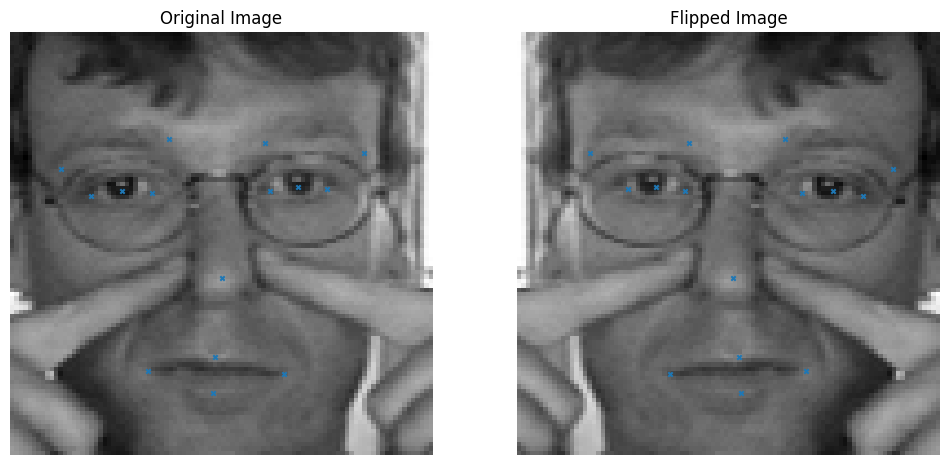

In [ ]:
#Ploting the original and the flipped images
img_index = 0
n = 0 # num of transformation
image, labels = x_train_augmented[img_index], y_train_augmented[img_index]

# Plot fliped image horizontaly
flipped_image, flipped_labels = x_train_augmented[img_index + numImg + n], y_train_augmented[img_index + numImg + n]
plot_sample_flipped(image, labels, flipped_image, flipped_labels)


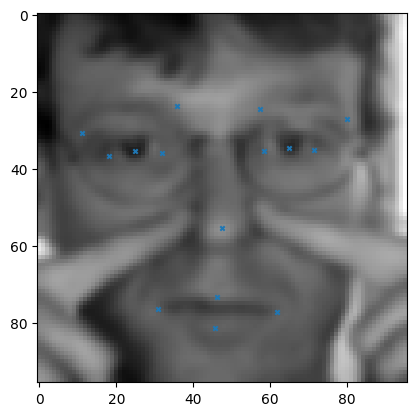

In [ ]:
# Ploting blurred image
n += 1
plot_sample(x_train_augmented[img_index + numImg + n], y_train_augmented[img_index + numImg + n])


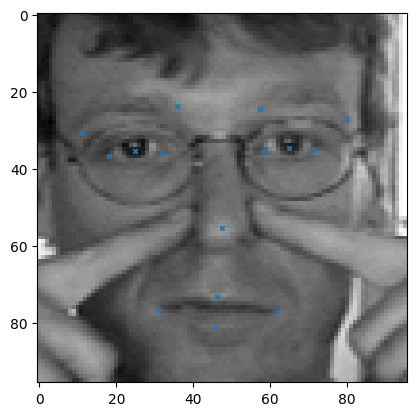

In [ ]:
# Plot darker image
n +=1
plot_sample(x_train_augmented[img_index + numImg + n], y_train_augmented[img_index + numImg + n])


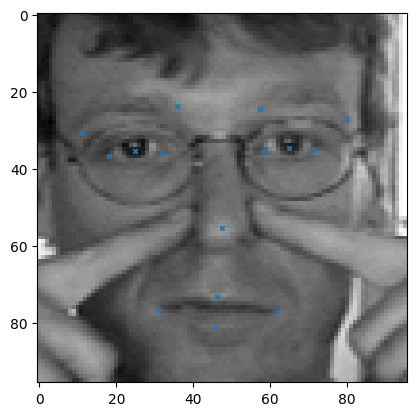

In [ ]:
# Plot lighter image
n +=1
plot_sample(x_train_augmented[img_index + numImg + n], y_train_augmented[img_index + numImg + n])

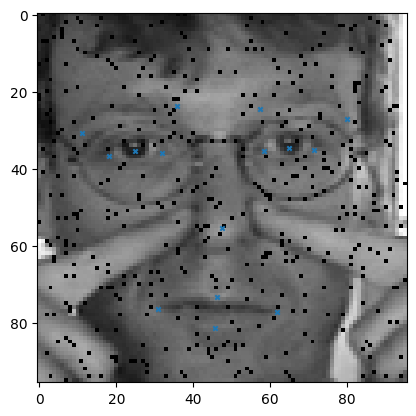

In [ ]:
# Plot image with drop outs
n +=1
plot_sample(x_train_augmented[img_index + numImg + n], y_train_augmented[img_index + numImg + n])

In [ ]:
print(x_train_augmented.shape)
print(y_train_augmented.shape)

(10272, 96, 96, 1)
(10272, 30)


In [ ]:
#NEW MODEL

# Hyperparameters
batch_size = 32
epochs = 200
input_shape = (96, 96, 1)
output_shape = 30

# Define a Sequential model
model = keras.Sequential(
    [
        # Input layer with specified input shape
        keras.Input(shape=input_shape),
        # Batch normalization to normalize activations
        layers.BatchNormalization(),

        # Feature extraction layers
        layers.Conv2D(16, kernel_size=(5, 5), activation="relu", padding="same"),
        layers.MaxPooling2D(pool_size=(2, 2)),

        layers.Conv2D(32, kernel_size=(5, 5), activation="relu", padding="same"),
        layers.MaxPooling2D(pool_size=(2, 2)),

        layers.Conv2D(64, kernel_size=(5, 5), activation="relu", padding="same"),
        layers.MaxPooling2D(pool_size=(2, 2)),

        layers.Conv2D(128, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D(pool_size=(2, 2)),

        layers.Conv2D(128, kernel_size=(3, 3), activation="relu", padding="same"),

        # Global Average Pooling to summarize spatial information
        layers.GlobalAveragePooling2D(),

        # Regression layers
        layers.Flatten(),
        layers.Dense(512, activation="relu"),

        # Dropout layer for regularization
        layers.Dropout(0.25),

        layers.Dense(90, activation="relu"),

        # Output layer with linear activation for regression
        layers.Dense(output_shape, activation="linear"),
    ]
)

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_2 (Bat  (None, 96, 96, 1)         4         
 chNormalization)                                                
                                                                 
 conv2d_10 (Conv2D)          (None, 96, 96, 16)        416       
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 48, 48, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 48, 48, 32)        12832     
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 24, 24, 32)        0         
 g2D)                                                            
                                                      

In [ ]:
from keras import backend as K

# Define a custom loss class for Root Mean Squared Error
class RootMeanSquaredError(tf.Module):
    def __init__(self):
        super().__init__()

    def __call__(self, y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))

    def get_config(self):
        # No additional configuration is needed
        return {}

# Create an instance of the custom loss
root_mean_squared_error = RootMeanSquaredError()

# Compile the model with the custom loss, Adam optimizer, and accuracy metric
model.compile(
    loss=root_mean_squared_error,
    optimizer="adam",
    metrics = ['accuracy']
)

# Set up early stopping with patience and restoring best weights
es = EarlyStopping(monitor='val_loss', mode='auto', patience=10,  restore_best_weights=True)

# Train the model with augmented data and early stopping
history = model.fit(
    x_train_augmented, y_train_augmented,
    epochs=epochs,
    validation_split=0.1,
    callbacks=[es])

Epoch 1/200
289/289 [==============================] - 6s 11ms/step - loss: 0.0838 - accuracy: 0.6582 - val_loss: 0.0636 - val_accuracy: 0.7179
Epoch 2/200
289/289 [==============================] - 3s 11ms/step - loss: 0.0676 - accuracy: 0.6947 - val_loss: 0.0599 - val_accuracy: 0.7179
Epoch 3/200
289/289 [==============================] - 3s 11ms/step - loss: 0.0622 - accuracy: 0.6963 - val_loss: 0.0560 - val_accuracy: 0.7179
Epoch 4/200
289/289 [==============================] - 4s 12ms/step - loss: 0.0558 - accuracy: 0.7059 - val_loss: 0.0492 - val_accuracy: 0.7189
Epoch 5/200
289/289 [==============================] - 3s 11ms/step - loss: 0.0458 - accuracy: 0.7175 - val_loss: 0.0379 - val_accuracy: 0.7529
Epoch 6/200
289/289 [==============================] - 3s 10ms/step - loss: 0.0383 - accuracy: 0.7392 - val_loss: 0.0333 - val_accuracy: 0.7656
Epoch 7/200
289/289 [==============================] - 3s 11ms/step - loss: 0.0337 - accuracy: 0.7624 - val_loss: 0.0307 - val_accuracy:

In [ ]:
y_new = model.predict(x_valid)

def rmse_pixel(y_true, y_pred):
        return np.sqrt(np.mean(np.square(y_pred*48 - y_true*48)))

print("Mean pixel error: ", rmse_pixel(y_valid, y_new))

7/7 [==============================] - 0s 4ms/step
Mean pixel error:  1.3380177


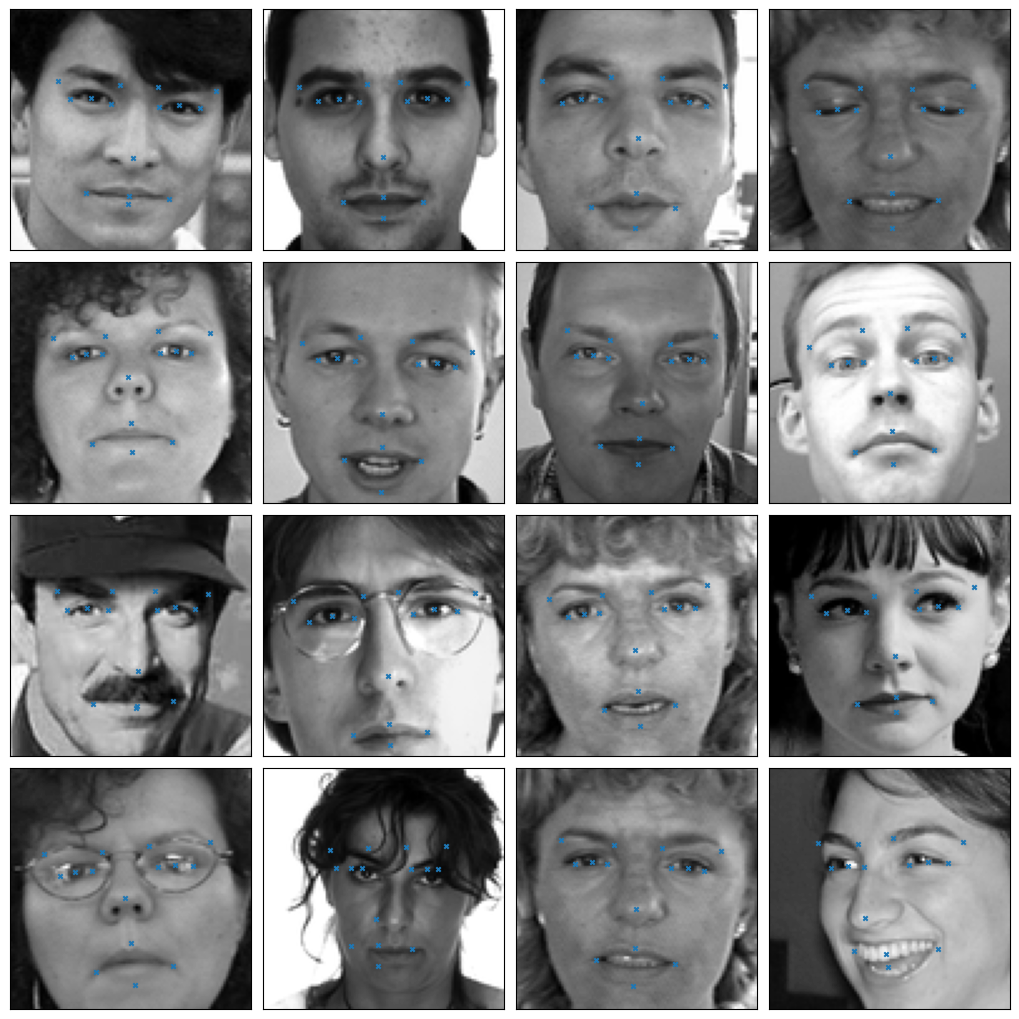

In [ ]:
fig = pyplot.figure(figsize=(10, 10))
fig.subplots_adjust(
    left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    plot_sample(x_valid[i,:,:,0],y_new[i])
pyplot.show()

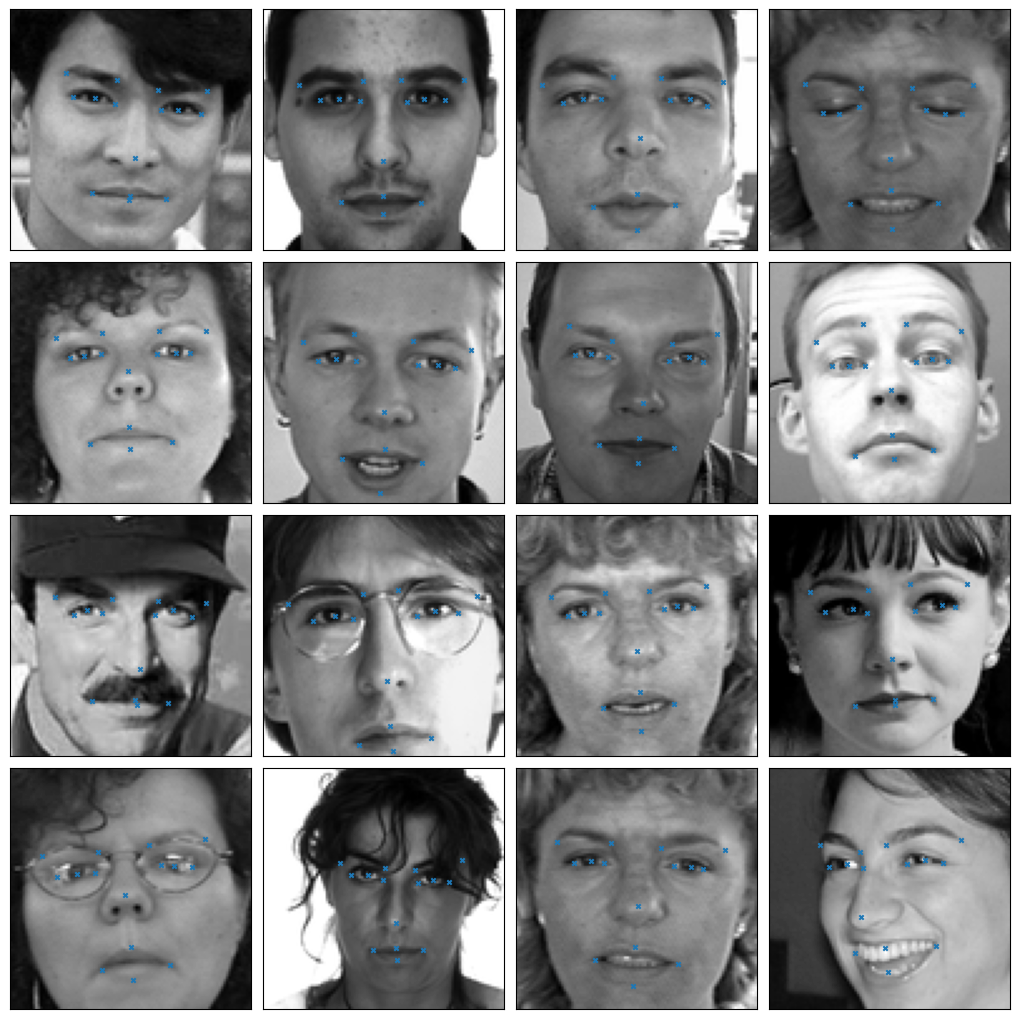

In [ ]:
fig = pyplot.figure(figsize=(10, 10))
fig.subplots_adjust(
    left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    plot_sample(x_valid[i,:,:,0],y_valid[i])

pyplot.show()

# Your solution

# Reporting

Please, report the results of your experiments in this cell.

## What is the best result you got when testing?  

> Results must be evaluated by computing the **mean error in pixel units**. If you get a mean error of 1.6 pixels is ok. If your get 1.5 is very good. If you get 1.3 or less, it is an outstanding result!

**Answer**: The mean pixel error is 1.3380177

## What architecture and tricks you used for that result?
### Describe your design strategy as well all those tricks that contributed to your result.


**Answer**:

Firstly, my primary emphasis was on data augmentation. To begin, I implemented image flipping, both horizontally and vertically. During this process, it became evident that the labels of each image needed to be adjusted accordingly. Specifically, for horizontal flipping, I also had to modify the position of the coordinates to maintain accuracy. Then, I extended the augmentation techniques to include variations such as adjusting image brightness, darkness, and introducing blur effects.

Following that, I proceeded to evaluate the mean pixel error using the existing model configuration without any modifications. The results, however, did not align with the expected outcomes. Consequently, I undertook a twofold approach: refining the data augmentation function and making adjustments to the model itself in an effort to improve performance.

Therefore, I experimented with rotation, zooming, and shearing, incorporating dropouts into the images during the augmentation process. After various attempts, I found that employing only dropouts yielded the most favorable results. Additionally, I realised that vertical flipping did not contribute positively to mean pixel accuracy. So, I decided to remove vertical flipping from the augmentation function.

After experimenting with various architectual choices and techniques for the model, I arrived to the previous Keras Sequential model. The inut layer is for grayscale images of 96x96 pixels. I introduced a Batch Normalization layer to enchance convergence and prevent overfitting. Then, I added subsequent convolutional layers with filter sizes of 16, 32, 64, and 128. Employing ReLU activation throughout ensure non-linearity, also I imputed some max-pooling layers to downsamples spatial dimensions and I opted  two dense layers with 512 and 90 neurons,respectively. Furthemore, before the last layer I itroduced a Dropout layer with dropout rate 0.25 to mitigate overfitting. The final outpout lauer, with linear activation and 30 neurons, aligns with the regression nature of the task. Lastly, this model, trained with a batch size of 32 for 200 epochs, emerged as an effective configuration after iterative experumentation.

Furthermore, I experimented with various optimizers, including Adam and SGD. After trying those two, it became evident that Adam emerged as the optimal choice for the experiment.

Ultimately, this strategic refinement resulted in a significant improvement, yielding a very good mean pixel error of 1.3380177. This outcome underscores the importance of careful consideration and fine-tuning in the augmentation process as well as defining the best model to achieve superior performance.